# Chapter 8: Tree-Based Methods
- **Chapter 8 from the book [An Introduction to Statistical Learning](https://www.statlearning.com/)**
- **By Gareth James, Daniela Witten, Trevor Hastie and Rob Tibshirani**
- **Pages from $333$ to $335$**
- **By [Mosta Ashour](https://www.linkedin.com/in/mosta-ashour/)**


**Exercises:**
- **[7.](#7)**
- **[8.](#8) [(a)](#8a) [(b)](#8b) [(c)](#8c) [(d)](#8d) [(e)](#8e)**
- **[9.](#9) [(a)](#9a) [(b)](#9b) [(c)](#9c) [(d)](#9d) [(e)](#9e) [(f)](#9f) [(g)](#9g) [(h)](#9h) [(i)](#9i) [(j)](#9j) [(k)](#9k)**
- **[10.](#10) [(a)](#10a) [(b)](#10b) [(c)](#10c) [(d)](#10d) [(e)](#10e) [(f)](#10f) [(g)](#10g)**
- **[11.](#11) [(a)](#11a) [(b)](#11b) [(c)](#11c)**
- **[12.](#12)**

# [Here!](#here)

# <span style="font-family:cursive;color:#0071bb;"> 8.4 Exercises </span>
## <span style="font-family:cursive;color:#0071bb;"> Applied </span>

In [1]:
import numpy as np
import pandas as pd
import patsy as pt
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn import tree, datasets, metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_text
from sklearn.ensemble import BaggingRegressor, BaggingClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from scripts.ch6 import lasso_cv
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier

<a id='7'></a>
### $7.$ In the lab, we applied random forests to the $\color{brown}{\text{Boston}}$ data using $\color{brown}{\text{mtry=6}}$ and using $\color{brown}{\text{ntree=25}}$ and $\color{brown}{\text{ntree=500}}$. Create a plot displaying the test error resulting from random forests on this data set for a more comprehensive range of values for $\color{brown}{\text{mtry}}$ and $\color{brown}{\text{ntree}}$. You can model your plot after Figure $8.10$. Describe the results obtained.

In [2]:
# Load boston dataset.
boston_df = datasets.load_boston()
boston_df = pd.DataFrame(data=np.c_[boston_df['data'], boston_df['target']],
                         columns= [c for c in boston_df['feature_names']] + ['Price'])

X_train, X_test, y_train, y_test = train_test_split(boston_df.drop('Price', axis=1),
                                                    boston_df.Price, 
                                                    test_size=0.3,
                                                    random_state=42)

boston_df.head()

# Create design and response matrix
#f = 'Price ~ ' + ' + '.join(boston_df.columns.drop(['Price']))
#y, X = pt.dmatrices(f, boston_df, return_type='dataframe')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [3]:
# fit random forests on a range of values for mtry and ntree
res = []
max_features = {'m=p=13': X_train.shape[1], 
                'm=10': 10,
                'm=7': 7,
                'm=4': 4,
                'm=2': 2,
                'm=1': 1}

for mtry in max_features:
    for ntree in range(1, 201):
        rfr = RandomForestRegressor(n_estimators=ntree,
                                    max_features=max_features[mtry],
                                    random_state=42)
        rfr.fit(X_train, y_train)
        pred = rfr.predict(X_test)
        mse = MSE(y_test, pred)
        rmse = np.sqrt(mse)
        res += [[ntree, mtry, rmse]]

res = pd.DataFrame(res, columns=['Number of Trees', 'mtry', 'Test RMSE'])

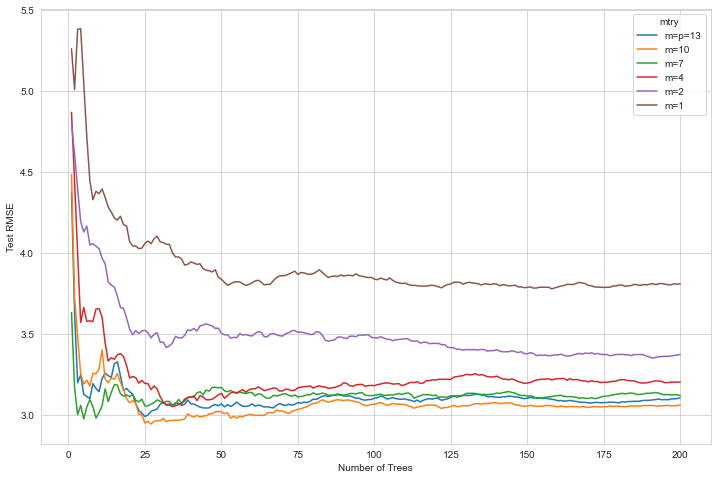

In [4]:
# displaying the test error results
plt.figure(figsize=(12,8))
sns.set_style('whitegrid')
sns.lineplot(x='Number of Trees', y='Test RMSE', hue='mtry', data=res);

> **Comment:**
>- The plot above shows test $\text{RMSE}$ where training set is $70\%$ and testing set with $30\%$ from the $\text{boston}$ dataset.
>- We can see that test $\text{RMSE}$ starts very high with a low number of trees, then starts to consists decrease by adding more trees then starts to stabilizes. And increasing the number of trees seem to no overfit the training set as test $\text{RMSE}$ keep decreasing.
>- The plot shows that as we increase max features (till it capture the best features from the dataset) we get better performance, and it is a bad idea to select a totally random variable at each split (mtry=1). 
>- Under the randomseed=42, with $m=7$ we get the best test $\text{RMSE}$ with a fewer number of trees. In this case, the $\text{RMSE}$ was actually lowest for mtry=10, but we can say results for mtry = [4, 7, 10, 13] are even close.

<a id='8'></a>
### $8.$ In the lab, a classification tree was applied to the $\color{brown}{\text{Carseats}}$ data set after converting $\color{brown}{\text{Sales}}$ into a qualitative response variable. Now we will seek to predict $\color{brown}{\text{Sales}}$ using regression trees and related approaches, treating the response as a quantitative variable.

<a id='8a'></a>
**$(a)$ Split the data set into a training set and a test set.**

In [5]:
# Load Carseats dataset.
carseats_df = pd.read_csv('datasets/Carseats.csv', index_col=0)

carseats_df_dum = pd.get_dummies(carseats_df, columns=['ShelveLoc', 'Urban', 'US'], drop_first=True)

# Split the data into 250/150 as in laps
X_train, X_test, y_train, y_test = train_test_split(carseats_df_dum.drop('Sales', axis=1), 
                                                    carseats_df_dum.Sales,
                                                    test_size=0.375)

carseats_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 1 to 400
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    object 
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    object 
 10  US           400 non-null    object 
dtypes: float64(1), int64(7), object(3)
memory usage: 37.5+ KB


<a id='8b'></a>
**$(b)$ Fit a regression tree to the training set. Plot the tree, and interpret the results. What test $\text{MSE}$ do you obtain?**

In [6]:
# fit regression tree with max_depth 4 for better visual
dtr = DecisionTreeRegressor(max_depth=4).fit(X_train, y_train)

# Measure test set MSE
pred = dtr.predict(X_test)
mse = MSE(y_test, pred)

# Get predicts on the test set
print('Test MSE: {:.3f}'.format(mse))
print('Test RMSE: {:.3f}'.format(np.sqrt(mse)))

Test MSE: 5.433
Test RMSE: 2.331


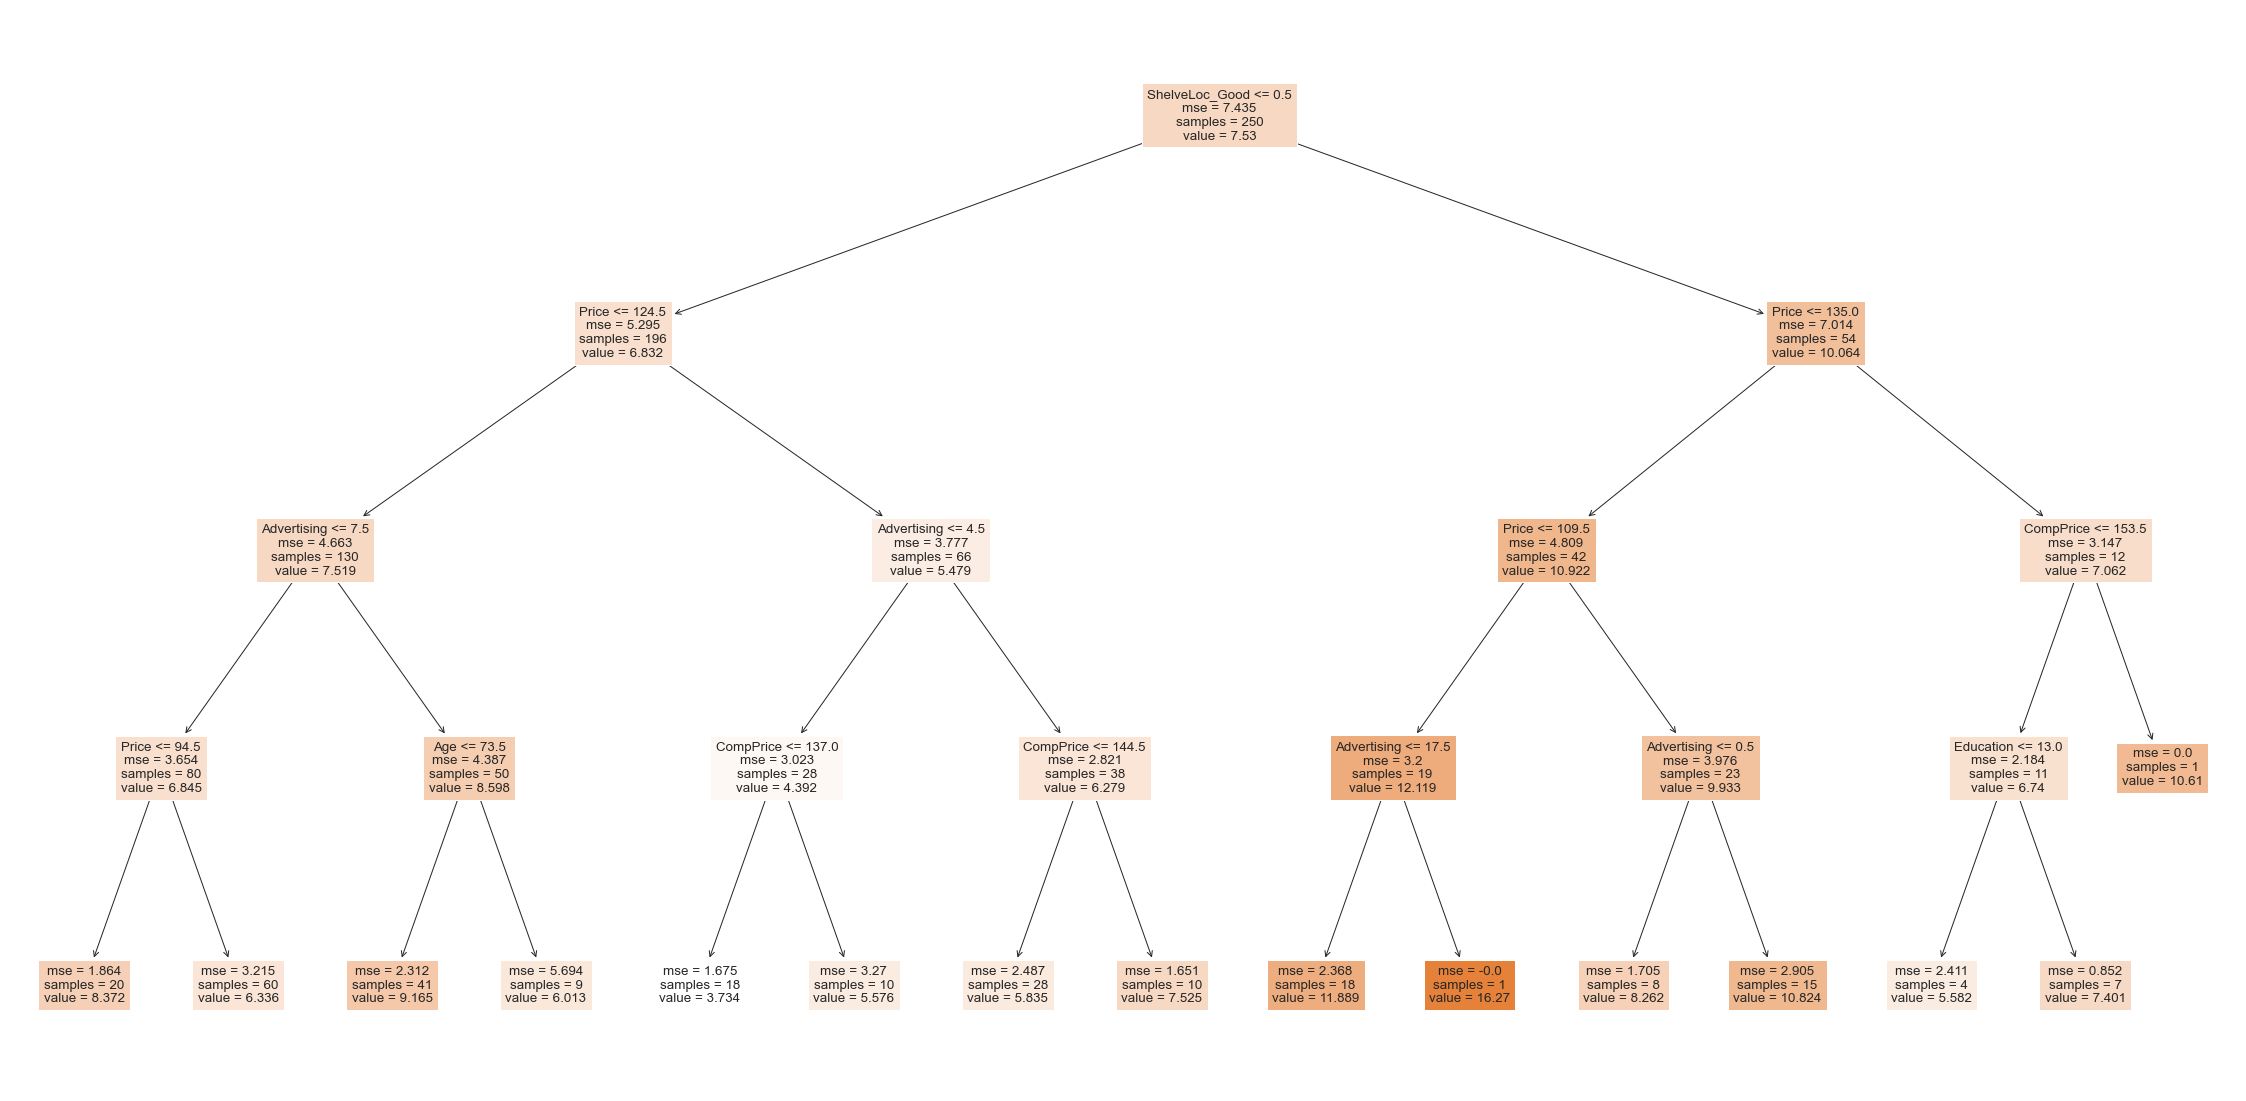

In [7]:
# plot the tree
plt.figure(figsize=(40,20))
tree.plot_tree(dtr,
               feature_names=X_train.columns,  
               class_names=y_train.name,
               filled=True);

<a id='8c'></a>
**$(c)$ Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test $\text{MSE}$?**

In [8]:
columns=['Tree_Size', 'Training', 'Cross-Validation', 'Test']

results = []
for m in range(2, 51):
    dtr = DecisionTreeRegressor(max_leaf_nodes=m)
    cv_scores = cross_val_score(dtr, X_train, y_train,
                                cv=10,
                                scoring='neg_mean_squared_error')
    dtr = dtr.fit(X_train, y_train)
    training = MSE(y_train, dtr.predict(X_train))
    test = MSE(y_test, dtr.predict(X_test))
    cv = np.mean(np.absolute(cv_scores))
    results += [[m, training, cv, test]]
    
res_df = pd.DataFrame(results, columns=columns).set_index('Tree_Size')

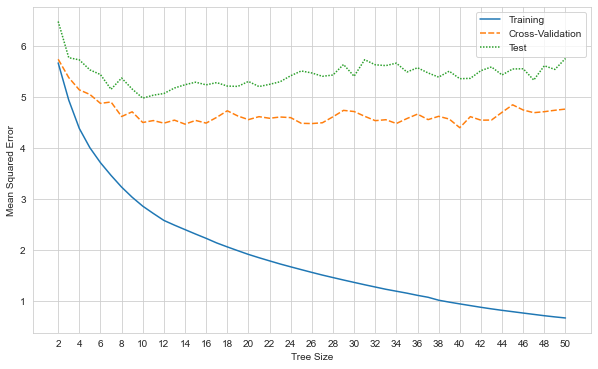

,Training,Cross-Validation,Test
Tree_Size,,,
40,0.940565,4.396164,5.357057
14,2.397409,4.465903,5.238922
26,1.558247,4.477223,5.469526
34,1.189063,4.478566,5.662043
25,1.612360,4.482430,5.508955


Test MSE : 5.306
Test RMSE: 2.304


In [9]:
# Regression tree analysis for Carseats dataset
plt.figure(figsize=(10,6))
sns.lineplot(data=res_df)
plt.xticks(range(2, 51, 2))
plt.xlabel('Tree Size')
plt.ylabel('Mean Squared Error')
plt.show();

# Show best model
best = res_df[res_df['Cross-Validation'] == res_df['Cross-Validation'].min()]

# Use chosen model for test prediction
dtr  = tree.DecisionTreeRegressor(max_leaf_nodes=int(best.index[0])).fit(X_train, y_train)
pred = dtr.predict(X_test)
mse = MSE(y_test, pred)

# Get proportion of correct classifications on test set
display(res_df.sort_values('Cross-Validation').head())
print('Test MSE : {:.3f}'.format(mse))
print('Test RMSE: {:.3f}'.format(np.sqrt(mse)))

> **Comment**
>- Using 10-fold cross-validation shows that a pruned tree does improve the test $\text{MSE}$, as the optimal level of tree complexity is $16$, with test $\text{MSE} = 4.639$. 
>- We can see that as the level of tree complexity increase, the model more to overfit the training set.

<a id='8d'></a>
**$(d)$ Use the bagging approach in order to analyze this data. What test $\text{MSE}$ do you obtain? Use the $\color{brown}{\text{importance()}}$ function to determine which variables are most important.**

In [10]:
# using BaggingRegressor() from Sklearn
bagging = BaggingRegressor(n_estimators=100,
                           random_state=42)
bagging.fit(X_train, y_train)
y_pred = bagging.predict(X_test)

mse = MSE(y_test, y_pred)
rmse = np.sqrt(mse)

print('Test MSE : {:.3f}'.format(mse))
print('Test RMSE: {:.3f}'.format(rmse))

Test MSE : 3.032
Test RMSE: 1.741


In [11]:
# We can implement bagging using RandomForestRegressor() 
# by setting max_features = #predictors = 11
bagging = RandomForestRegressor(max_features=X_train.shape[1],
                                random_state=42)
bagging.fit(X_train, y_train)
y_pred = bagging.predict(X_test)

mse = MSE(y_test, y_pred)
rmse = np.sqrt(mse)

print('Test MSE : {:.3f}'.format(mse))
print('Test RMSE: {:.3f}'.format(rmse))

Test MSE : 3.002
Test RMSE: 1.733


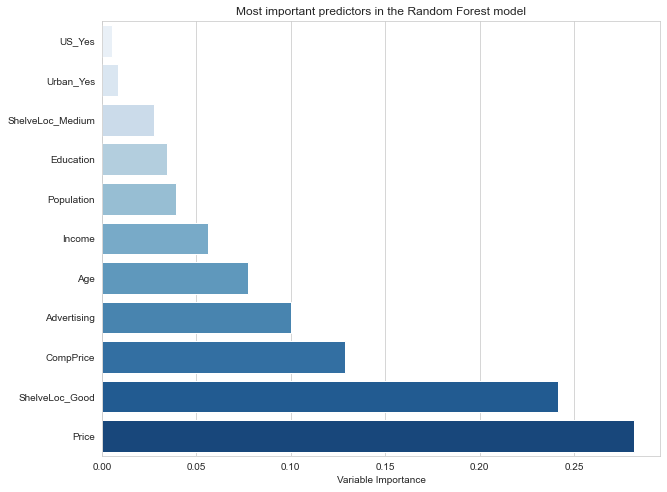

In [12]:
# Plot feature by importance
res_df = pd.DataFrame({'Feature': X_train.columns, 'Variable Importance': bagging.feature_importances_})
res_df = res_df.sort_values('Variable Importance')

plt.figure(figsize=(10,8))
sns.barplot(x='Variable Importance', y='Feature', data=res_df, palette='Blues')
plt.title('Most important predictors in the Random Forest model')
plt.ylabel('');

>**Comment:**
>- Bagging yields a significant improvement in the test $\text{MSE}=2.692$ compared to the optimal pruned tree of $4.639$.
>- And we can see that in bagging trees determine that $\text{ShelveLoc_Good}$ and $\text{Price}$ are the most important variables affecting $\text{Sales}$.


<a id='8e'></a>
**$(e)$ Use random forests to analyze this data. What test $\text{MSE}$ do you obtain? Use the $\color{brown}{\text{importance()}}$ function to determine which variables are most important. Describe the effect of $m$, the number of variables considered at each split, on the error rate obtained.**

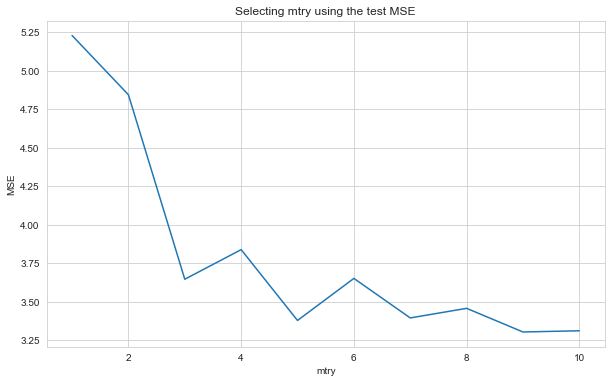

In [13]:
# fit random forests on a range of values for mtry and ntree
res = []

for mtry in range(1, X_train.shape[1]):
    for ntree in range(1, 51):
        rfr = RandomForestRegressor(n_estimators=ntree,
                                    max_features=mtry,
                                    random_state=42)
        rfr.fit(X_train, y_train)
        pred = rfr.predict(X_test)
        mse = MSE(y_test, pred)
        res += [[ntree, mtry, mse]]

res = pd.DataFrame(res, columns=['Number of Trees', 'mtry', 'MSE'])

# displaying the test error results
mtry_v = res.groupby('mtry')['MSE'].mean()

plt.figure(figsize=(10,6))
sns.set_style('whitegrid')
sns.lineplot(data=mtry_v)
plt.title('Selecting mtry using the test MSE')
plt.show();

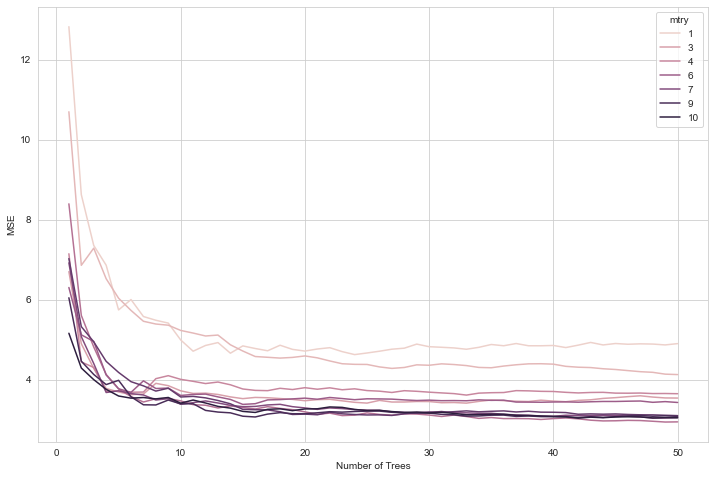

In [14]:
# displaying the test error results
plt.figure(figsize=(12,8))
sns.set_style('whitegrid')
sns.lineplot(x='Number of Trees', y='MSE', hue='mtry', data=res)
plt.show();

In [15]:
# fit Random Forest with 100 trees and 10 features considered at each split

rfr = RandomForestRegressor(n_estimators=100,
                            max_features=10,
                            random_state=42)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

mse = MSE(y_test, y_pred)
rmse = np.sqrt(mse)

print('Test MSE : {:.3f}'.format(mse))
print('Test RMSE: {:.3f}'.format(rmse))

Test MSE : 2.995
Test RMSE: 1.731


**Using the $\color{brown}{\text{importance()}}$ function to determine which variables are most important:**

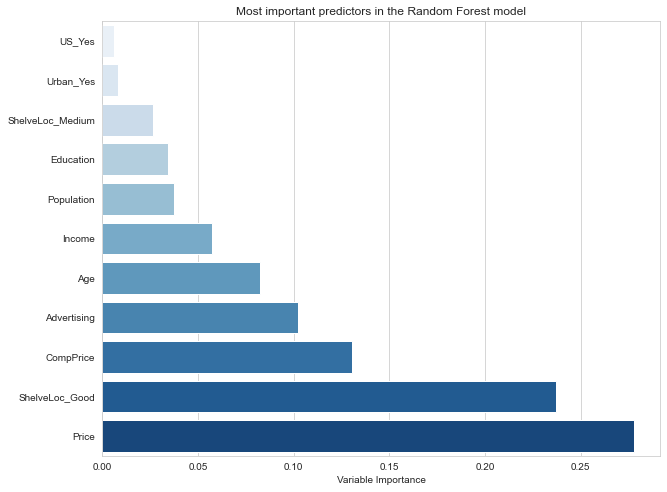

In [16]:
# Plot feature by importance
res_df = pd.DataFrame({'Feature': X_train.columns, 'Variable Importance': rfr.feature_importances_})
res_df = res_df.sort_values('Variable Importance')

plt.figure(figsize=(10,8))
sns.barplot(x='Variable Importance', y='Feature', data=res_df, palette='Blues')
plt.title('Most important predictors in the Random Forest model')
plt.ylabel('');

> **Comment:**
>- We can see with $\text{mtry}=1$ the model has the highest $\text{test MSE}$ and starts to decrease by increasing $\text{mtry}$ (Negative correlation).
>- The best random forest model used $\text{mtry}$ of 10, which is the same as bagging tree model. As we used the same $\text{mtry}$ in bagging.
>- For sure we can see that the variables importance identical to the bagging tree model $(8.d.)$.

<a id='9'></a>
### $9.$ This problem involves the $\color{brown}{\text{OJ}}$ data set which is part of the $\color{brown}{\text{ISLR}}$ package.

In [17]:
# read OJ dataset
oj_df = pd.read_csv('datasets/oj.csv', index_col=0)

# get dummies from categorical columns
oj_df = pd.get_dummies(oj_df, columns=['Purchase', 'Store7'], drop_first=True, dtype=np.int64)
oj_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1070 entries, 1 to 1070
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   WeekofPurchase  1070 non-null   int64  
 1   StoreID         1070 non-null   int64  
 2   PriceCH         1070 non-null   float64
 3   PriceMM         1070 non-null   float64
 4   DiscCH          1070 non-null   float64
 5   DiscMM          1070 non-null   float64
 6   SpecialCH       1070 non-null   int64  
 7   SpecialMM       1070 non-null   int64  
 8   LoyalCH         1070 non-null   float64
 9   SalePriceMM     1070 non-null   float64
 10  SalePriceCH     1070 non-null   float64
 11  PriceDiff       1070 non-null   float64
 12  PctDiscMM       1070 non-null   float64
 13  PctDiscCH       1070 non-null   float64
 14  ListPriceDiff   1070 non-null   float64
 15  STORE           1070 non-null   int64  
 16  Purchase_MM     1070 non-null   int64  
 17  Store7_Yes      1070 non-null   i

<a id='9a'></a>
**$(a)$ Create a training set containing a random sample of $800$ observations, and a test set containing the remaining observations.**

In [18]:
# Split the data into 800/270
X_train, X_test, y_train, y_test = train_test_split(oj_df.drop('Purchase_MM', axis=1), 
                                                    oj_df.Purchase_MM,
                                                    train_size=800,
                                                    random_state=42)

<a id='9b'></a>
**$(b)$ Fit a tree to the training data, with $\color{brown}{\text{Purchase}}$ as the response and the other variables as predictors. Use the $\color{brown}{\text{summary()}}$ function to produce summary statistics about the tree, and describe the results obtained. What is the training error rate? How many terminal nodes does the tree have?**

In [19]:
# Fit Sklearns tree classifier with max_depth of 4 for better visual 
# "as we get 160 terminal nodes as random"
dtc = DecisionTreeClassifier(max_depth=4, random_state=42).fit(X_train, y_train)
y_pred_train = dtc.predict(X_train)

print('Training Error Rate (MSE): {:.3f}'.format(MSE(y_train, y_pred_train)))
print(f'Terminal Nodes: {dtc.tree_.n_leaves}')

Training Error Rate (MSE): 0.145
Terminal Nodes: 16


**Determine which variables are most important:**

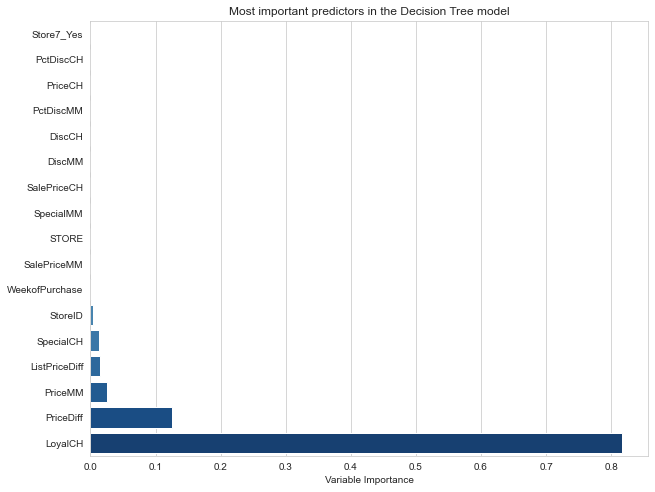

In [20]:
# Plot feature by importance
res_df = pd.DataFrame({'Feature': X_train.columns, 'Variable Importance': dtc.feature_importances_})
res_df = res_df.sort_values('Variable Importance')

plt.figure(figsize=(10,8))
sns.barplot(x='Variable Importance', y='Feature', data=res_df, palette='Blues')
plt.title('Most important predictors in the Decision Tree model')
plt.ylabel('');

<a id='9c'></a>
**$(c)$ Type in the name of the tree object in order to get a detailed text output. Pick one of the terminal nodes, and interpret the information displayed.**

In [21]:
# print text for the first left leave from our tree
r = export_text(dtc, feature_names=list(X_train.columns), max_depth=200) #The full tree
print(r[:r.find('\n|---', 1)])

|--- LoyalCH <= 0.50
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.06
|   |   |   |--- WeekofPurchase <= 268.50
|   |   |   |   |--- class: 1
|   |   |   |--- WeekofPurchase >  268.50
|   |   |   |   |--- class: 1
|   |   |--- LoyalCH >  0.06
|   |   |   |--- LoyalCH <= 0.21
|   |   |   |   |--- class: 1
|   |   |   |--- LoyalCH >  0.21
|   |   |   |   |--- class: 1
|   |--- LoyalCH >  0.28
|   |   |--- PriceDiff <= 0.05
|   |   |   |--- SpecialCH <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- SpecialCH >  0.50
|   |   |   |   |--- class: 0
|   |   |--- PriceDiff >  0.05
|   |   |   |--- ListPriceDiff <= 0.26
|   |   |   |   |--- class: 1
|   |   |   |--- ListPriceDiff >  0.26
|   |   |   |   |--- class: 0


> Let's pick terminal node ```WeekofPurchase <= 268.50``` which is a child of the following splits: 
>```
|--- LoyalCH <= 0.50
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.04```

<a id='9d'></a>
**$(d)$ Create a plot of the tree, and interpret the results.**

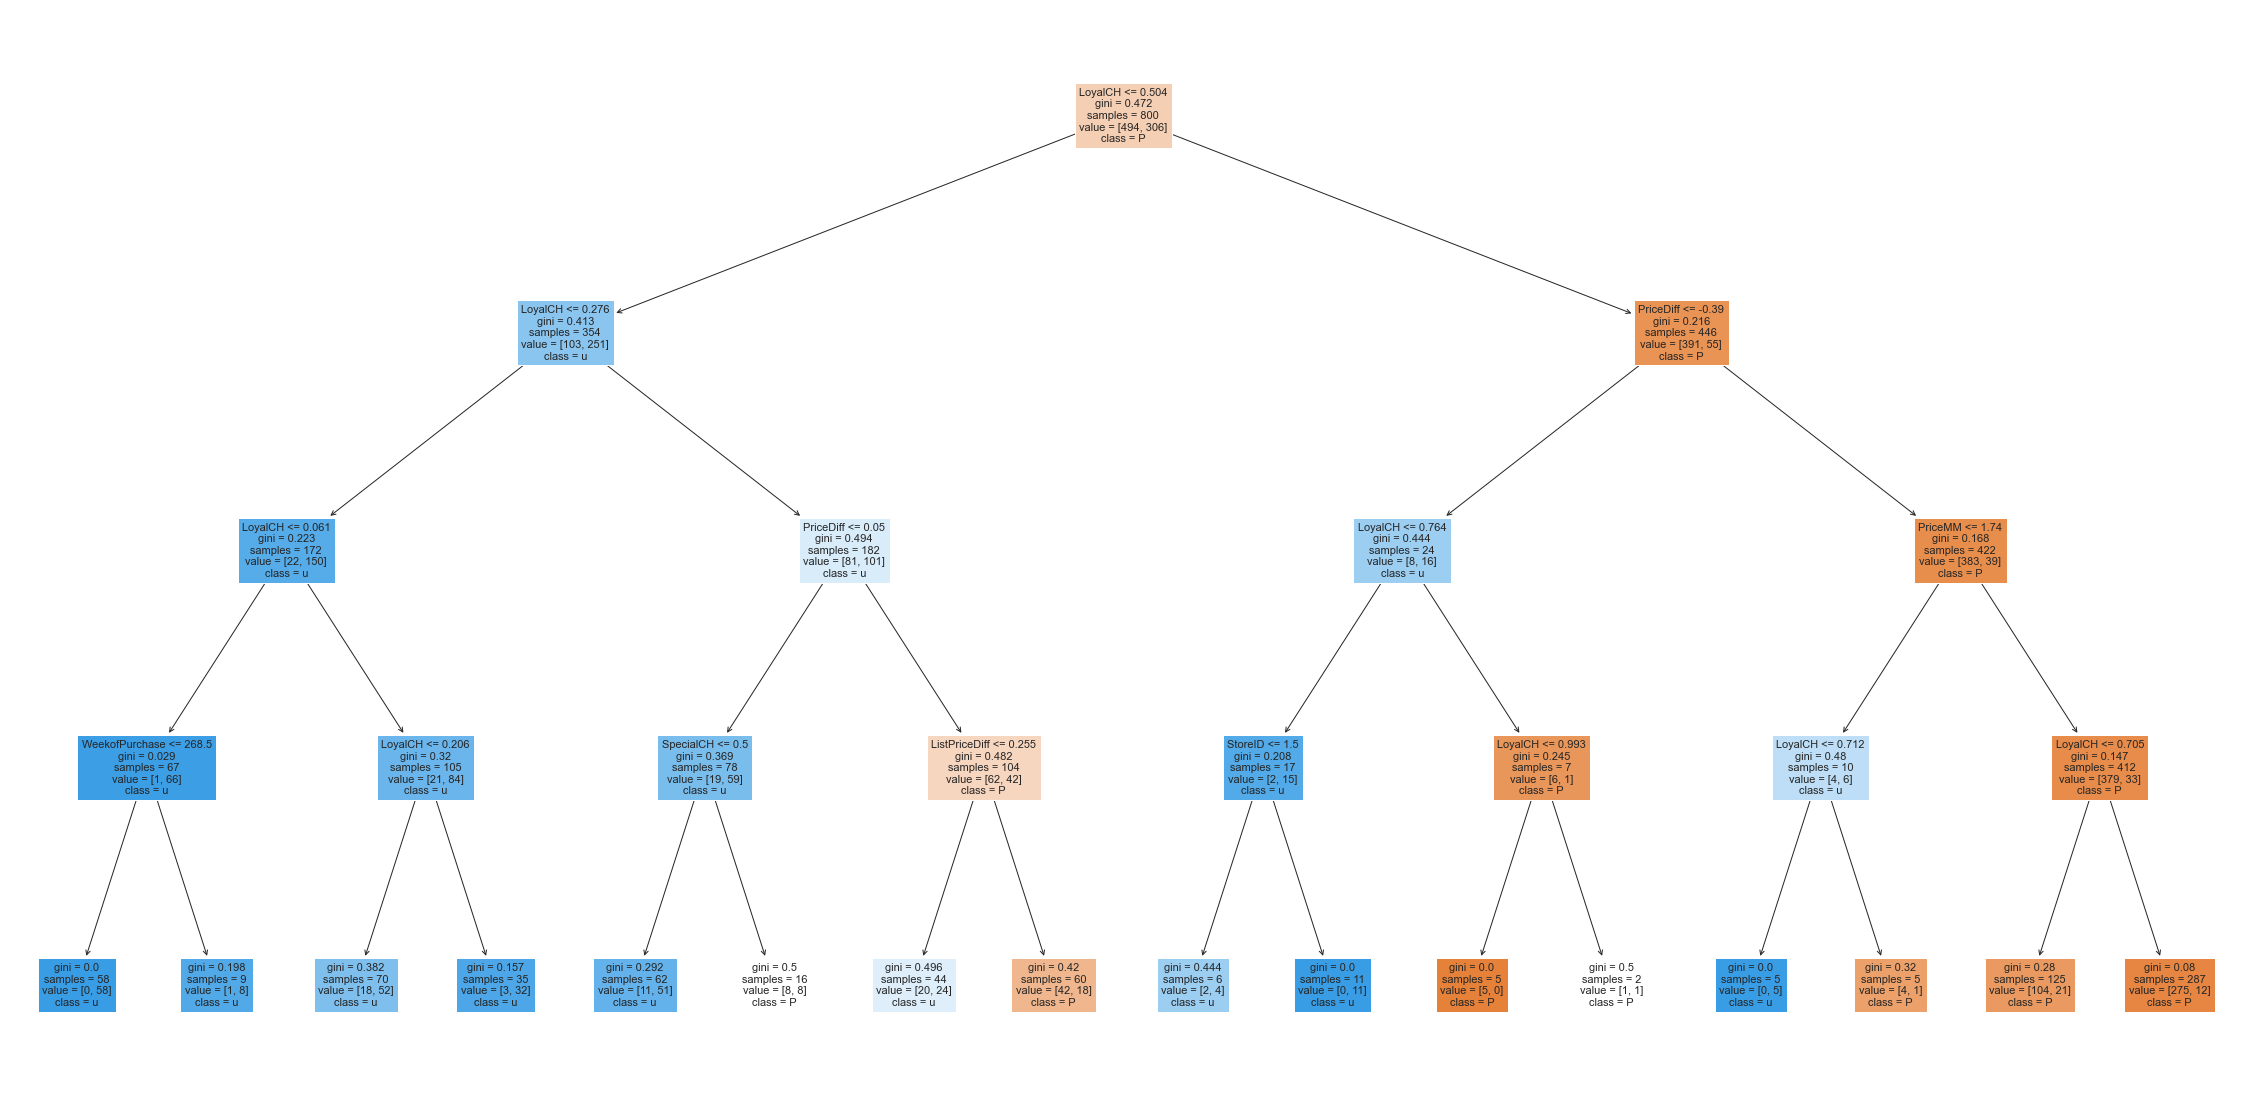

In [22]:
# Convert this cell to "Code" to view the tree
# plot the Classifier Tree
plt.figure(figsize=(40,20))
tree.plot_tree(dtc,
               feature_names=X_train.columns,  
               class_names=y_train.name,
               filled=True);

<a id='9e'></a>
**$(e)$ Predict the response on the test data, and produce a confusion matrix comparing the test labels to the predicted test labels. What is the test error rate?**

In [23]:
# Here's the confusion matrix
y_pred = dtc.predict(X_test)
print(confusion_matrix(y_test, y_pred))

test_mse = MSE(y_pred, y_test)
print('\ntest error rate: {}'.format(np.around(test_mse, 3)))

[[129  30]
 [ 35  76]]

test error rate: 0.241


<a id='9f'></a>
**$(f)$ Apply the $\color{brown}{\text{cv.tree()}}$ function to the training set in order to determine the optimal tree size.**

In [24]:
# Estimate optimal tree with cross validation on training set
results = []

for m in range(2, 51):
    dtc = DecisionTreeClassifier(max_leaf_nodes=m, random_state=42)
    cv_scores = cross_val_score(dtc, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    mse = np.mean(np.abs(cv_scores))
    results += [[m, mse]]
    
res_df = pd.DataFrame(results, columns=['Leaves', 'MSE'])

<a id='9g'></a>
**$(g)$ Produce a plot with tree size on the $\text{x-axis}$ and cross-validated classification error rate on the $\text{y-axis}$.**

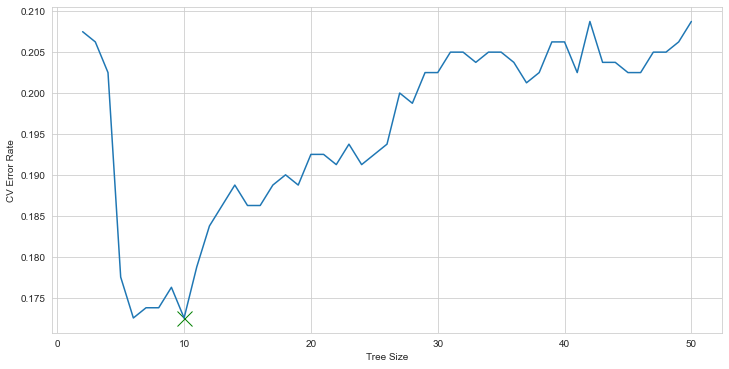

In [25]:
# select tree size the lowest MSE
best_tree = res_df[res_df.MSE == res_df.min().MSE]

# Showing the best tree size with a green x
plt.figure(figsize=(12,6))
plt.plot(best_tree.Leaves, best_tree.MSE, 'rx', c='g', ms=15)
sns.lineplot(x='Leaves', y='MSE', data=res_df)
plt.xlabel('Tree Size')
plt.ylabel('CV Error Rate')
plt.show();

<a id='9h'></a>
**$(h)$ Which tree size corresponds to the lowest cross-validated classification error rate?**

In [26]:
best_tree

,Leaves,MSE
8,10,0.1725


<a id='9i'></a>
**$(i)$ Produce a pruned tree corresponding to the optimal tree size obtained using cross-validation. If cross-validation does not lead to selection of a pruned tree, then create a pruned tree with five terminal nodes.**

In [27]:
dtc_pruned = DecisionTreeClassifier(max_leaf_nodes=8).fit(X_train, y_train)
dtc_unpruned = DecisionTreeClassifier().fit(X_train, y_train)

<a id='9j'></a>
**$(j)$ Compare the training error rates between the pruned and unpruned trees. Which is higher?**

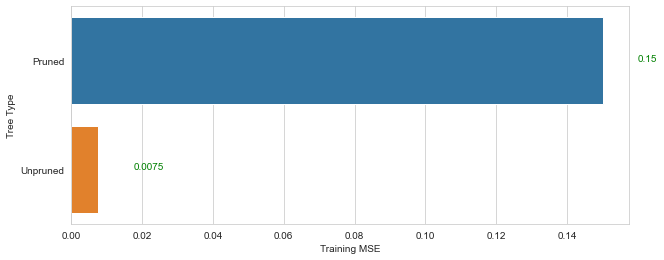

In [28]:
res_df = pd.DataFrame([['Pruned', 1-dtc_pruned.score(X_train, y_train)],
                       ['Unpruned', 1-dtc_unpruned.score(X_train, y_train)]], 
                      columns=['Tree Type', 'Training MSE'])

plt.figure(figsize=(10, 4))
ax = sns.barplot(x='Training MSE', y='Tree Type', data=res_df)
for i, v in enumerate(res_df['Training MSE']):
    ax.text(v+.01, i, str(round(v, 4)), color='g');

> Unpruned tree perform way better than the Pruned one "8 max leaf nodes". And that isn't surprising as we increase leaves "model complexity increase", as the model more to overfit the Training dataset.

<a id='9k'></a>
**$(k)$ Compare the test error rates between the pruned and unpruned trees. Which is higher?**

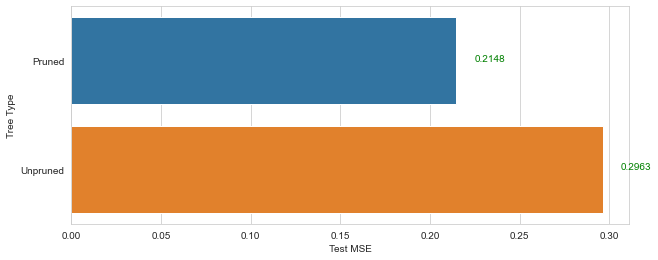

In [29]:
res_df = pd.DataFrame([['Pruned', 1-dtc_pruned.score(X_test, y_test)],
                       ['Unpruned', 1-dtc_unpruned.score(X_test, y_test)]], 
                      columns=['Tree Type', 'Test MSE'])

plt.figure(figsize=(10, 4))
ax = sns.barplot(x='Test MSE', y='Tree Type', data=res_df)
for i, v in enumerate(res_df['Test MSE']):
    ax.text(v+.01, i, str(round(v, 4)), color='g');

>- As we expected, Unpruned Tree **overfit** the Training dataset leading to poor perform in the Testing set.
>- Otherwise, the pruned Tree performs very well in the Testing set as in Training set, which indicates to an optimum model.

<a id='10'></a>
### $10.$ We now use boosting to predict $\color{brown}{\text{Salary}}$ in the $\color{brown}{\text{Hitters}}$ data set.

<a id='10a'></a>
**$(a)$ Remove the observations for whom the salary information is unknown, and then log-transform the salaries.**

In [30]:
# read the Hitters dataset 
hitters_df = pd.read_csv('datasets/Hitters.csv').dropna()

# remove unknown information
hitters_df = hitters_df.dropna()

# log-transform the Salaries
hitters_df['Salary'] = hitters_df.Salary.apply(np.log)

<a id='10b'></a>
**$(b)$ Create a training set consisting of the first 200 observations, and a test set consisting of the remaining observations.**

In [31]:
# firstly, let's convert the categorical data into dummies 
hitters_df = pd.get_dummies(hitters_df, drop_first=True, dtype=np.int64)

# Splitting the data set into 200/63
X_train, X_test, y_train, y_test = train_test_split(hitters_df.drop('Salary', axis=1),
                                                    hitters_df.Salary,
                                                    train_size=200,
                                                    random_state=42)

<a id='10c'></a>
**$(c)$ Perform boosting on the training set with $1,000$ trees for a range of values of the shrinkage parameter $\lambda$. Produce a plot with different shrinkage values on the $\text{x-axis}$ and the corresponding training set $\text{MSE}$ on the $\text{y-axis}$.**

In [32]:
# boosting
results = []
for lr in np.logspace(-10, np.log(1), 50): 
    gbr = GradientBoostingRegressor(learning_rate=lr,
                                    n_estimators=1000,
                                    random_state=42)
    gbr.fit(X_train, y_train)
    pred_train = gbr.predict(X_train)
    pred_test  = gbr.predict(X_test)
    
    train_mse = MSE(y_train, pred_train)
    test_mse  = MSE(y_test, pred_test)
    
    results += [[lr, train_mse, test_mse]]
    
res_df = pd.DataFrame(results, columns=['Learning_Rate', 'Train_MSE', 'Test_MSE'])

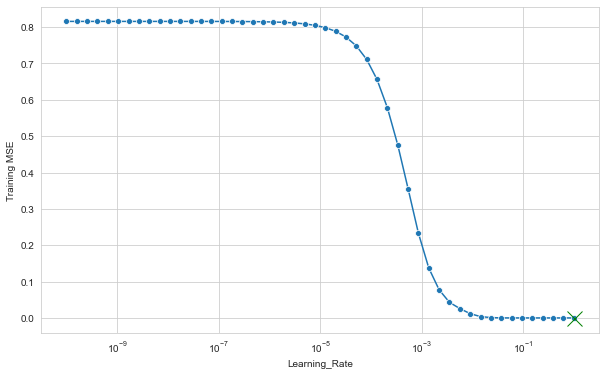

In [33]:
best_boosting_train = res_df.sort_values('Train_MSE').iloc[0]
best_boosting_test  = res_df.sort_values('Test_MSE').iloc[0]

plt.figure(figsize=(10,6))
sns.lineplot(x='Learning_Rate', y='Train_MSE', data=res_df, marker='o')
plt.plot(best_boosting_train.Learning_Rate, best_boosting_train.Train_MSE, 'rx', c='g', ms=15)
plt.xscale('log')
plt.ylabel('Training MSE')
plt.show();

<a id='10d'></a>
**$(d)$ Produce a plot with different shrinkage values on the x-axis and the corresponding test set MSE on the y-axis.**

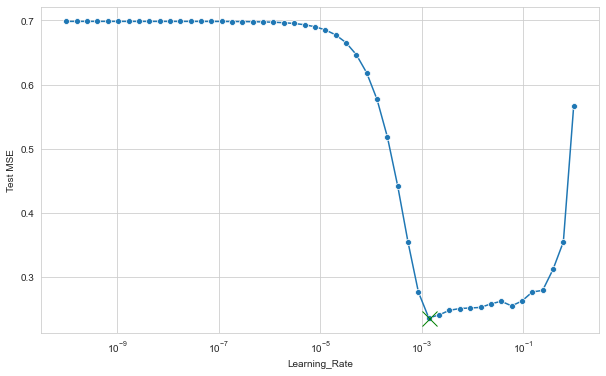

In [34]:
plt.figure(figsize=(10,6))
sns.lineplot(x='Learning_Rate', y='Test_MSE', data=res_df, marker='o')
plt.plot(best_boosting_test.Learning_Rate, best_boosting_test.Test_MSE, 'rx', c='g', ms=15)
plt.xscale('log')
plt.ylabel('Test MSE')
plt.show();

<a id='10e'></a>
**$(e)$ Compare the test $\text{MSE}$ of boosting to the test $\text{MSE}$ that results from applying two of the regression approaches seen in Chapters $3$ and $6$.**

- **Regression approach Ch3 "Ordinary Least Squares"**

In [35]:
# Regression approach adding intercept
X_train_intercept = X_train.copy()
X_train_intercept['intercept'] = 1
X_test_intercept = X_test.copy()
X_test_intercept['intercept'] = 1

# fit model
model = sm.OLS(y_train, X_train_intercept,).fit()
y_pred = model.predict(X_test_intercept)

test_mse_ols = MSE(y_test, y_pred)
print('MSE test: {:.3f}'.format(test_mse_ols))

MSE test: 0.447


- **Regression approach Ch6 "Lasso"**

In [36]:
# lasso model using cv for the best Lambda
lambdas = np.arange(0.2, 20, .1)
MSEs    = [] 

for l in lambdas:
    MSEs += [np.mean(lasso_cv(X_train, y_train, l, k=10))]
    
res_df = pd.DataFrame({'Lambda': lambdas, 'MSE': MSEs})
best_lasso_train = res_df.sort_values('MSE').iloc[0]
best_lasso_train

Lambda    6.800000
MSE       0.440941
Name: 66, dtype: float64

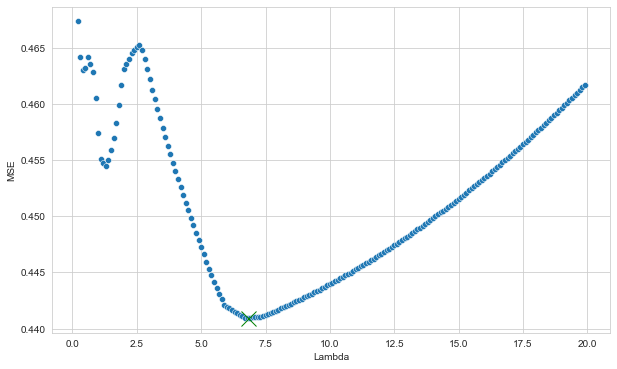

In [37]:
# plot best Lambda value
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Lambda', y='MSE', data=res_df)
plt.plot(best_lasso_train.Lambda, best_lasso_train.MSE, 'rx', c='g', ms=15)
plt.show();

In [38]:
# Fit Lasso model with the best Lambda
model = Lasso(alpha=best_lasso_train.Lambda,
              fit_intercept=True,
              normalize=False,
              max_iter=1000000)

model.fit(X_train, y_train)

# Measure MSE
y_pred = model.predict(X_test)
test_mse_lasso = MSE(y_test, y_pred)

**Comparison between the Three models (OLS, Lasso, Boosting)**

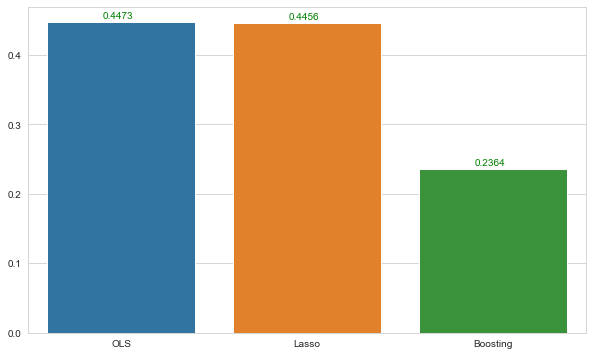

In [39]:
test_mses = pd.DataFrame({'OLS': test_mse_ols, 
                          'Lasso': test_mse_lasso,
                          'Boosting': best_boosting_test.Test_MSE}, index=[0])

# plot box plot for MSEs comparison
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=test_mses)
for i, v in enumerate(test_mses.loc[0]):
    ax.text(i-0.1, v+0.005, str(round(v, 4)), color='g');

> **Comment:**
>- **Boosting** with $\text{MSE}$ of $0.2364$ performs significantly better in the test set than both **Ordinary Least Squares ($0.4473$)** and **Lasso ($0.4456$)**

<a id='10f'></a>
**$(f)$ Which variables appear to be the most important predictors in the boosted model?**

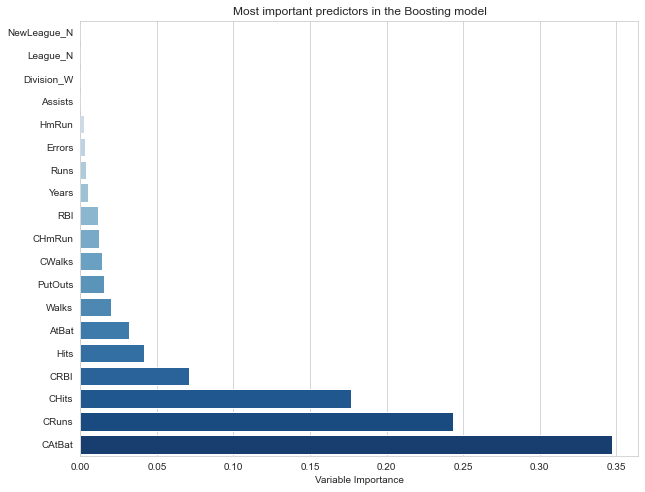

In [40]:
# fit best boosting model
lr = best_boosting_test.Learning_Rate
gbr = GradientBoostingRegressor(learning_rate=lr,
                                n_estimators=1000,
                                random_state=42)

gbr.fit(X_train, y_train)

# Plot feature by importance
res_df = pd.DataFrame({'Feature': X_train.columns, 'Variable Importance': gbr.feature_importances_})
res_df = res_df.sort_values('Variable Importance')

plt.figure(figsize=(10,8))
sns.barplot(x='Variable Importance', y='Feature', data=res_df, palette='Blues')
plt.title('Most important predictors in the Boosting model')
plt.ylabel('');

> **Comment:**
>- The **boosting** model suggests that the most important predictor of **Salary** from the **Hitters** dataset is **CAtBat** which is the "Number of times at bat during his career".
>- Follows by **CRuns**, **CHits**, and **CRBI**

<a id='10g'></a>
**$(g)$ Now apply bagging to the training set. What is the test set $\text{MSE}$ for this approach?**

In [41]:
# fit bagging model
bagging = BaggingRegressor(n_estimators=100,
                           random_state=42)
bagging.fit(X_train, y_train)

y_pred = bagging.predict(X_test)
mse = MSE(y_test, y_pred)
test_mses['Bagging'] = mse

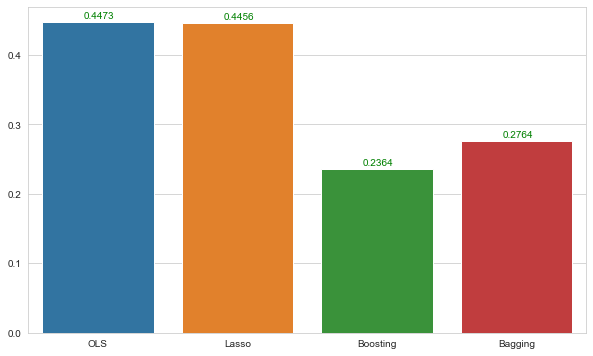

In [42]:
# plot box plot for MSEs comparison
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=test_mses)

for i, v in enumerate(test_mses.loc[0]):
    ax.text(i-0.1, v+0.005, str(round(v, 4)), color='g');

>- Bagging achieves Test $\text{MSE} = 0.2764$ "Under our random state of $42$" slightly close to the **Boosting** model.
slia test $\text{MSE}$ of 0.208 which is equivalent to that achieved by boosting. Bagging has the advantage here that the result was achived without need to tune hyper-parameters.

<a id='11'></a>
### $11.$ This question uses the $\color{brown}{\text{Caravan}}$ data set.

<a id='11a'></a>
**$(a)$ Create a training set consisting of the first $1,000$ observations, and a test set consisting of the remaining observations.**

In [43]:
# read caravan dataset
caravan_df = pd.read_csv('datasets/Caravan.csv', index_col=0)

# convert categorical variable to numeric 
caravan_df = pd.get_dummies(caravan_df, drop_first=True)

# split the dataset into 1000/~
train = caravan_df.iloc[:1000]
test = caravan_df.iloc[1000:]

print(f'Training shape: {train.shape}\
        \nTesting shape: {test.shape}')

Training shape: (1000, 86)        
Testing shape: (4822, 86)


> In this case, the train set has pretty fewer observations than the test split of $1000/4822$ split.

<a id='11b'></a>
**$(b)$ Fit a boosting model to the training set with $\color{brown}{\text{Purchase}}$ as the response and the other variables as predictors. Use $1,000$ trees, and a shrinkage value of $0.01$. Which predictors appear to be the most important?**

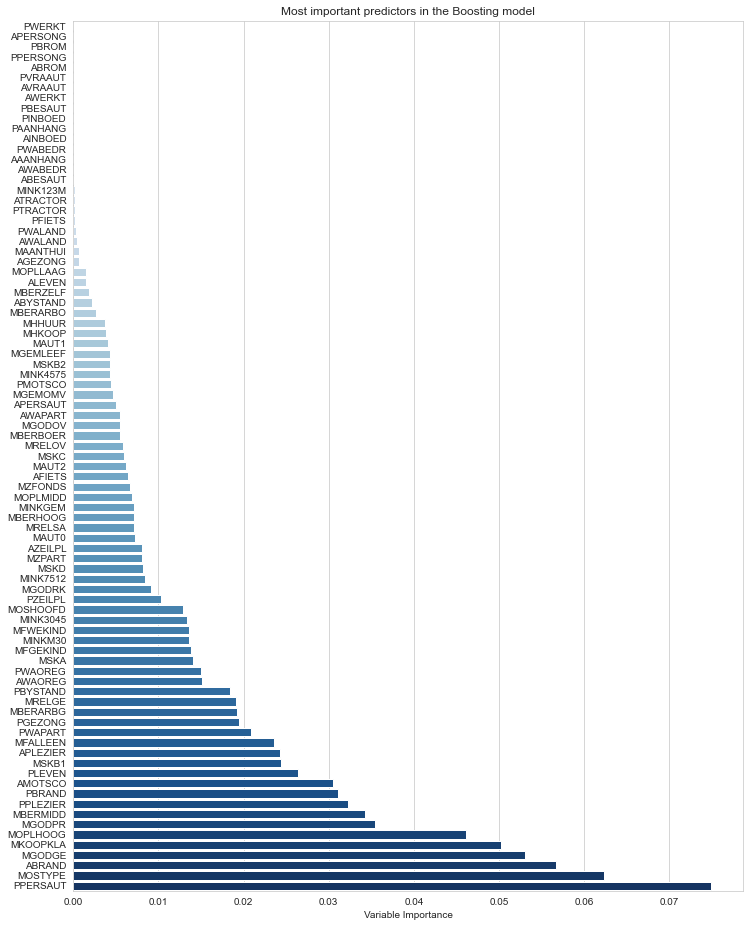

In [44]:
# split data into X and y without random state "first 1000"
X_train = train.drop('Purchase_Yes', axis=1)
y_train = train.Purchase_Yes
X_test = test.drop('Purchase_Yes', axis=1)
y_test = test.Purchase_Yes

# fit boosting model
boosting = GradientBoostingClassifier(learning_rate=0.01,
                                      n_estimators=1000,
                                      random_state=42)
boosting.fit(X_train, y_train)

# Plot feature by importance
res_df = pd.DataFrame({'Feature': X_train.columns, 'Variable Importance': boosting.feature_importances_})
res_df = res_df.sort_values('Variable Importance')

plt.figure(figsize=(12,16))
sns.barplot(x='Variable Importance', y='Feature', data=res_df, palette='Blues')
plt.title('Most important predictors in the Boosting model')
plt.ylabel('');

>- As we can see, the most important predictor is **PPERSAUT = "Contribution car policies"**, following by **MOSTYPE, MGODGE, ABRAND** and **MKOOPKLA**. 
"You can check their definitions from [Here](https://www.kaggle.com/datasets/uciml/caravan-insurance-challenge)."

<a id='11c'></a>
**$(c)$ Use the boosting model to predict the response on the test data. Predict that a person will make a purchase if the estimated probability of purchase is greater than $20\%$. Form a confusion matrix. What fraction of the people predicted to make a purchase do in fact make one? How does this compare with the results obtained from applying $\text{KNN}$ or logistic regression to this data set?**

## Boosting

In [45]:
# predict the response on the test data
y_pred_prob = boosting.predict_proba(X_test)
y_pred = (y_pred_prob[:, 1] > 0.2).astype(int)
score_boosting = sum(y_pred == y_test)/len(y_test)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:", cm, sep='\n')

Confusion Matrix:
[[4335  198]
 [ 251   38]]


In [46]:
# What fraction of the people predicted to make a purchase do in fact make one?
pos_pred_boost = (cm[:, 1][1]/np.sum(cm[:, 1]))
print("The Positive predictive value is: {:.2f}%".format(pos_pred_boost*100))
print("Boosting score is: {:.2f}%".format(score_boosting*100))

The Positive predictive value is: 16.10%
Boosting score is: 90.69%


## KNN

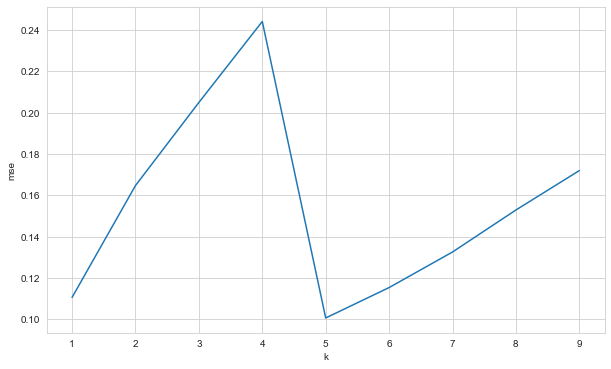

In [47]:
# fit KNN model
res = []
for k in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    y_pred_prob = knn.predict_proba(X_test)
    y_pred = (y_pred_prob[:, 1] > 0.2).astype(int)
    mse = MSE(y_pred, y_test)
    res += [[k, mse]]

res_df = pd.DataFrame(res, columns=['k', 'mse'])

# plot to pick the best k value
plt.figure(figsize=(10, 6))
sns.lineplot(x='k', y='mse', data=res_df);

In [48]:
# fit knn with the best k value
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)
y_pred_prob = knn.predict_proba(X_test)
y_pred = (y_pred_prob[:, 1] > 0.2).astype(int)
score_knn = sum(y_pred == y_test)/len(y_test)

cm_knn = confusion_matrix(y_test, y_pred)
print("KNN Confusion Matrix:", cm_knn, sep='\n')

KNN Confusion Matrix:
[[4310  223]
 [ 262   27]]


In [49]:
# What fraction of the people predicted to make a purchase do in fact make one?
pos_pred_knn = (cm_knn[:, 1][1]/np.sum(cm_knn[:, 1]))
print("The Positive predictive value is: {:.2f}%".format(pos_pred_knn*100))
print("KNN score is: {:.2f}%".format(score_knn*100))

The Positive predictive value is: 10.80%
KNN score is: 89.94%


## Logistic Regression

In [50]:
# fit Logistic Regression model
log_r = LogisticRegression(max_iter=1000).fit(X_train, y_train)
y_pred_prob = log_r.predict_proba(X_test)
y_pred = (y_pred_prob[:, 1] > 0.2).astype(int)
score_log = sum(y_pred == y_test)/len(y_test)

cm_log = confusion_matrix(y_test, y_pred)
print("Logistic Regression Confusion Matrix:", cm, sep='\n')

Logistic Regression Confusion Matrix:
[[4335  198]
 [ 251   38]]


In [51]:
# What fraction of the people predicted to make a purchase do in fact make one?
pos_pred_log = (cm_log[:, 1][1]/np.sum(cm_log[:, 1]))
print("The Positive predictive value is: {:.2f}%".format(pos_pred_log*100))
print("Logistic Regression score is: {:.2f}%".format(score_log*100))

The Positive predictive value is: 17.30%
Logistic Regression score is: 90.09%


## Comparison

In [52]:
res = [['Logistic Regression', pos_pred_log, score_log],
       ['KNN', pos_pred_knn, score_knn],
       ['Boosting', pos_pred_boost, score_boosting]]
res_df = pd.DataFrame(res, columns=['model', 'Positive predictive v', 'score'])
res_df

,model,Positive predictive v,score
0,Logistic Regression,0.173010,0.900871
1,KNN,0.108000,0.899419
2,Boosting,0.161017,0.906885


>**Comment:**
>- Under the same criteria with the estimated probability of Purchase is greater than $20\%$ for the three approaches, **Logistic Regression** model slightly performs better than the **Boosting** model with positive predictive of $0.1730$ to $0.1610$ respectively. Over all both tend to perform pretty much the same.
>- The **KNN** in this case performs the worst $0.1080$.

<a id='12'></a>
### $12.$ Apply *boosting*, *bagging*, and *random forests* to a data set of your choice. Be sure to fit the models on a training set and to evaluate their performance on a test set. How accurate are the results compared to simple methods like *linear* or *logistic regression*? Which of these approaches yields the best performance?

> Let's test these approaches on the Boston dataset, which you can get from [Kaggle](https://www.kaggle.com/c/titanic). The data is already within our dataset folder, so you don't have to make any action so far.

> Let's firstly load the dataset which it's been split already in train and test sets, we will focus on just the train set now which contains the response **"Survived"**.

In [53]:
# data preprocessing and cleaning for titanic dataset

def titanic_preprocessing(file_dir):
    df = pd.read_csv(file_dir)
    df = df.drop(['PassengerId', 'Cabin', 'Name', 'Ticket'], axis=1)
    
    # fill missing ages with age mean
    df['Age'].fillna(df.Age.mean(), inplace=True)
    
    # drop any other missing
    df.dropna(inplace=True)
    
    # get dummies
    df = pd.get_dummies(df, columns=['Pclass', 'Sex', 'Embarked'], drop_first=True)
    return df

titanic_df = titanic_preprocessing('datasets/titanic_train.csv')

# Splitting the data set into 0.7/0.3
X_train, X_test, y_train, y_test = train_test_split(titanic_df.drop('Survived', axis=1),
                                                    titanic_df.Survived,
                                                    test_size=0.3,
                                                    random_state=42)

## Boosting

In [54]:
# fit boosting model
boosting = GradientBoostingClassifier(learning_rate=0.01,
                                     n_estimators=1000,
                                     random_state=42)
boosting.fit(X_train, y_train)

y_pred = boosting.predict(X_test)
score_boost = boosting.score(X_test, y_test)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Boosting Confusion Matrix:", cm, sep='\n')

Boosting Confusion Matrix:
[[149  18]
 [ 30  70]]


## Bagging

In [55]:
# fit bagging model
bagging = BaggingClassifier(n_estimators=1000,
                            random_state=42)
bagging.fit(X_train, y_train)

y_pred = bagging.predict(X_test)
score_bagging = bagging.score(X_test, y_test)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Bagging Confusion Matrix:", cm, sep='\n')

Bagging Confusion Matrix:
[[141  26]
 [ 31  69]]


## Random Forests

In [56]:
# fit random forest model
rfc = RandomForestClassifier(n_estimators=29,
                             max_features=6,
                             random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
score_rfc = rfc.score(X_test, y_test)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Random Forests Confusion Matrix:", cm, sep='\n')

Random Forests Confusion Matrix:
[[141  26]
 [ 30  70]]


## Decision Tree Classifier

In [57]:
# fit decision tree model
dtc = DecisionTreeClassifier(max_depth=4).fit(X_train, y_train)
y_pred = dtc.predict(X_test)
score_dtc = dtc.score(X_test, y_test)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Decision Tree Confusion Matrix:", cm, sep='\n')

Decision Tree Confusion Matrix:
[[153  14]
 [ 36  64]]


## Logistic Regression

In [58]:
log_r = LogisticRegression(max_iter=1000).fit(X_train, y_train)
y_pred = log_r.predict(X_test)
score_log = log_r.score(X_test, y_test)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Decision Tree Confusion Matrix:", cm, sep='\n')

Decision Tree Confusion Matrix:
[[141  26]
 [ 28  72]]


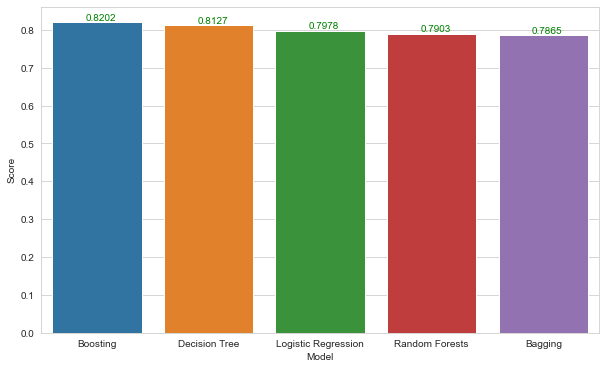

In [59]:
score_df = pd.DataFrame([["Boosting", score_boost],
                         ['Bagging', score_bagging],
                         ['Random Forests', score_rfc],
                         ['Decision Tree', score_dtc],
                         ['Logistic Regression', score_log]], columns=['Model', 'Score'])
score_df.sort_values('Score', ascending=False, inplace=True)

# plot box plot for score comparison
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Score', data=score_df)

for i, v in enumerate(score_df.Score):
    ax.text(i-0.1, v+0.005, str(round(v, 4)), color='g');

> **Comment:**
>- Overall we can simply say all these approaches performs slightly petter or worse than a simple method as **Logistic Regression**.
>- But as we can see, **Boosting** model tend to perform the best under our criteria, following by **Decision Tree** approach which both perform better than the **Logistic Regression** model.
>- Otherwise, **Random Forests** and **Bagging** performs worst even than the simple **Logistic Regression**, and that's unusual. Maybe we can get better performance with more adjustments for the parameters or using Cross Validation and so on.

# Done!